In [1]:
import glob
import numpy as np
from model_load_test import date_to_num, num_to_date
import pandas as pd
from pred import SSVI
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
from collections import namedtuple

import arviz as az
import pymc as pm
import xarray as xr

ff='./ssvi_params_SPX_call.csv'
train_sample=3000
CV=1000

colnames = ['rho', 'beta', 'mu', 'alpha', 'nu', 'date']
df = pd.read_csv(ff)

# XXX: The original dataset
dfo = df.copy()
dfo = dfo[colnames]
dfo.index = pd.to_datetime(dfo['date'])
dfo = dfo.drop('date', axis=1)

# XXX: Scaling alpha for outliers
from sklearn.preprocessing import MinMaxScaler
# alpha_scaler = MinMaxScaler((-1, 1)).fit(np.log(df['alpha']).values.reshape(-1, 1))
# res = alpha_scaler.fit_transform(np.log(df['alpha'].values).reshape(-1, 1))
# alpha_scaler = np.log(df['alpha']).values.reshape(-1, 1)
# res = np.log(df['alpha'].values).reshape(-1, 1)
df['alpha'] = np.log(df['alpha'])
# beta_scaler = MinMaxScaler((0, 1)).fit(df['beta'].values.reshape(-1, 1))
# df['beta'] = beta_scaler.fit_transform(df['beta'].values.reshape(-1, 1))
# nu_scaler = MinMaxScaler((0, 1)).fit(df['nu'].values.reshape(-1, 1))
# df['nu'] = nu_scaler.fit_transform(df['nu'].values.reshape(-1, 1))

# scalers = {'alpha': alpha_scaler
           # 'beta': beta_scaler, 'nu': nu_scaler
          # }
# scalers = {}

# from statsmodels.stats.descriptivestats import describe
# print(describe(df))
df_train = df[colnames][:train_sample]

In [2]:
# XXX: Performing grid search for lags in AR with Ridge and XGBoost
BAYAR = namedtuple('BAYAR', ['score', 'lags', 'model', 'tForecast'])
# FIXME: Include this later
_ = {i: BAYAR(-np.inf, 0, None, None) for i in colnames[:-1]}

In [13]:
def build_samples(df, lag):
    """Makes input and output samples (AR style) for training models
    given dataframe df and lag L.

    """

    train_sample = df.shape[0]
    samples = list()
    response = list()
    assert (train_sample - lag > 0)
    for i in range(train_sample-lag):
        samples.append(df.iloc[i:lag+i].values)
        res = df.iloc[lag + i]
        res = res.values if len(df.shape) > 1 else res
        response.append(res)
        # response.append(df.iloc[lag+i].values)

    samples = np.array(samples)
    response = np.array(response)
    return samples, response

In [28]:
# This is the number of samples we will go through for training
N = 3000
colnames = ['rho', 'date']
IS = range(5, 6)
train_sample = N

In [29]:
import pytensor as pt
# pt.config.floatX="float32"
# pt.config.warn_float64="raise"
# pt.config.openmp=True
from pymc.pytensorf import collect_default_updates
p = 5
arlags = [-1*i for i in range(p+1)]
q = 2
malags = [-1*i for i in range(1,q+1)]
v = colnames[0]
with pm.Model() as model:
    dof = pm.HalfCauchy("dof", beta=10**2)
    sigma = pm.HalfCauchy('sigma', beta=10)
    w = pm.Uniform("ws", lower=-1, upper=1, shape=p) # These are the ar weights
    ew = pm.Uniform("ew" , lower=-1, upper=1, shape=q) # These are the ma weights
    # w = pm.Normal("ws", shape=p) # These are the ar weights
    # ew = pm.Normal("ew", shape=q) # These are the ma weights
    intercept = pm.Uniform("intercept", lower=-1, upper=1) # The intercept
    Y = pm.Data("Y", df_train[v]) # This is the input
    def step(*args):
        # The first p+1 args are the previous 0 and then p lags of Y inputs
        ytrue = args[0] # the current "t" input
        ys = list(args[1:p+1]) # previous lagged ar inputs
        errs = list(args[p+1:p+1+q]) # previous error terms
        intercept, w, ew, sigma, dof = args[p+1+q:] # The weights
        yp = w.dot(ys) + intercept + ew.dot(errs)
        # Likelihood function
        yhat = pm.StudentT.dist(mu=yp, sigma=sigma, nu=dof)
        # yp = yp + ew.dot(errs) if len(errs) > 0 else yp
        epsilon = ytrue - yp
        return (epsilon, yhat), collect_default_updates([yhat, epsilon])
    
    # err0 = pm.Normal("initial_err")
    err0 = pt.tensor.zeros(shape=q)[0] if q == 1 else pt.tensor.zeros(shape=q)
    initials = [{'initial': err0, 'taps': malags}, None]
    [epsilons, yhat], updates = pt.scan(
        fn=step,
        sequences=[{'input': Y, 'taps': arlags}],
        outputs_info=initials,
        non_sequences=[intercept, w, ew, sigma, dof],
        strict=True, allow_gc=False
    )
    # pm.Deterministic('errors', epsilons)
    tresponse = pm.Data("tresponse", df_train[v][p:].values)
    model.register_rv(yhat, name='response', observed=tresponse) # P(DATA) fitting/sampling
    # pm.find_MAP(model=model, return_raw=True, maxeval=10000)

In [ ]:
import pymc.sampling.jax as pmjax
with model:
    # idata = pmjax.sample_blackjax_nuts(draws=1000, tune=1000, target_accept=0.95)
    idata = pmjax.sample_numpyro_nuts(draws=1000, tune=1000, target_accept=0.95)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
az.plot_trace(idata)

In [ ]:
az.summary(idata)

In [ ]:
az.plot_posterior(idata)

In [ ]:
with model:
    pm.set_data({"Y": dfo[v][train_sample-p:],
                 "tresponse": np.zeros(df[v][train_sample-p:].shape[0])})
    idata.extend(pm.sample_posterior_predictive(idata, predictions=False))

In [ ]:
bpred = idata.posterior_predictive['response'].mean(['chain', 'draw'])
real = df[v][train_sample:]
dfn = pd.DataFrame({'real': real.values, 'pred': bpred.values}, index=real.index)
print('Out-sample r2: ', r2_score(dfn['real'], dfn['pred'])*100)
print('RMSE Out-sample: ', root_mean_squared_error(dfn['real'], dfn['pred']))
print('MAPE Out-sample: ', np.sum((dfn['real'] - dfn['pred'])/dfn['real'])/(dfn.shape[0])*100)
dfn.plot(title='%s prediction' % v)

In [14]:
for v in colnames[:-1]:
    for i in IS:
        df_test = df[v][train_sample-i:train_sample+CV]
        df_test_i = df['date'][train_sample:train_sample+CV]
        df_test.index = df['date'][train_sample-i:train_sample+CV]
        samples, response = build_samples(df_train[v], i)
        dates = df_train['date'][i:]
        samples = pd.DataFrame(samples, columns=['AR%s' % j for j in range(i)])
        response = pd.DataFrame(response, columns=[v])
        samples.index = pd.to_datetime(dates)
        response.index = pd.to_datetime(dates)

        # XXX: Take only the first N samples
        
        assert (N <= train_sample)
        tsamples = samples.iloc[:N]
        tresponse = response.iloc[:N]
        tresponse = tresponse.values.reshape(-1,)

        # XXX: AR coefficients to include
        ARS = range(i)
        for k in ARS:
            assert (k < i)
        # XXX: Name of weights and sample columns
        wsnames = ['w%s' % c for c in ARS]
        coefnames = ['AR%s' % c for c in ARS]
        
        with pm.Model() as bayesmodel:
            tsamples = pm.Data("tsamples", tsamples)
            tresponse = pm.Data("tresponse", tresponse)
            intercept = pm.Normal("intercept", sigma=100**2)
            # XXX: variance for LL distribution
            sigma = pm.HalfCauchy('sigma', beta=10)
            ws = [pm.Uniform(w, lower=-1, upper=1) for w in wsnames]
            dof = pm.HalfCauchy('dof', beta=10**2)
            _ = pm.StudentT('response',
                            nu=dof,
                            mu=intercept+tsamples.dot(ws),
                            sigma=sigma,
                            observed=tresponse)
            #approx = pm.fit()
            idata = pm.sample(8000, tune=8000, cores=10)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [intercept, sigma, w0, w1, w2, w3, w4, dof]


Output()

Sampling 10 chains for 8_000 tune and 8_000 draw iterations (80_000 + 80_000 draws total) took 13 seconds.


In [15]:
test_samples, test_response = build_samples(df_test, i)

In [16]:
test_samples = pd.DataFrame(test_samples, columns=['AR%s' % j for j in range(i)])
test_response = pd.DataFrame(test_response, columns=[v])
test_samples.index = df_test_i
test_response.index = df_test_i
print(test_samples.head())
print(test_response.head())
print(test_samples.shape)

                 AR0       AR1       AR2       AR3       AR4
date                                                        
2002-07-03 -1.362479 -1.357039 -1.277106 -1.613294 -1.072214
2002-07-05 -1.357039 -1.277106 -1.613294 -1.072214 -1.138770
2002-07-08 -1.277106 -1.613294 -1.072214 -1.138770 -1.611865
2002-07-09 -1.613294 -1.072214 -1.138770 -1.611865 -1.366176
2002-07-10 -1.072214 -1.138770 -1.611865 -1.366176 -1.201223
               alpha
date                
2002-07-03 -1.138770
2002-07-05 -1.611865
2002-07-08 -1.366176
2002-07-09 -1.201223
2002-07-10 -1.314415
(1000, 5)


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w0'}>, <Axes: title={'center': 'w0'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'w2'}>, <Axes: title={'center': 'w2'}>],
       [<Axes: title={'center': 'w3'}>, <Axes: title={'center': 'w3'}>],
       [<Axes: title={'center': 'w4'}>, <Axes: title={'center': 'w4'}>],
       [<Axes: title={'center': 'dof'}>, <Axes: title={'center': 'dof'}>]],
      dtype=object)

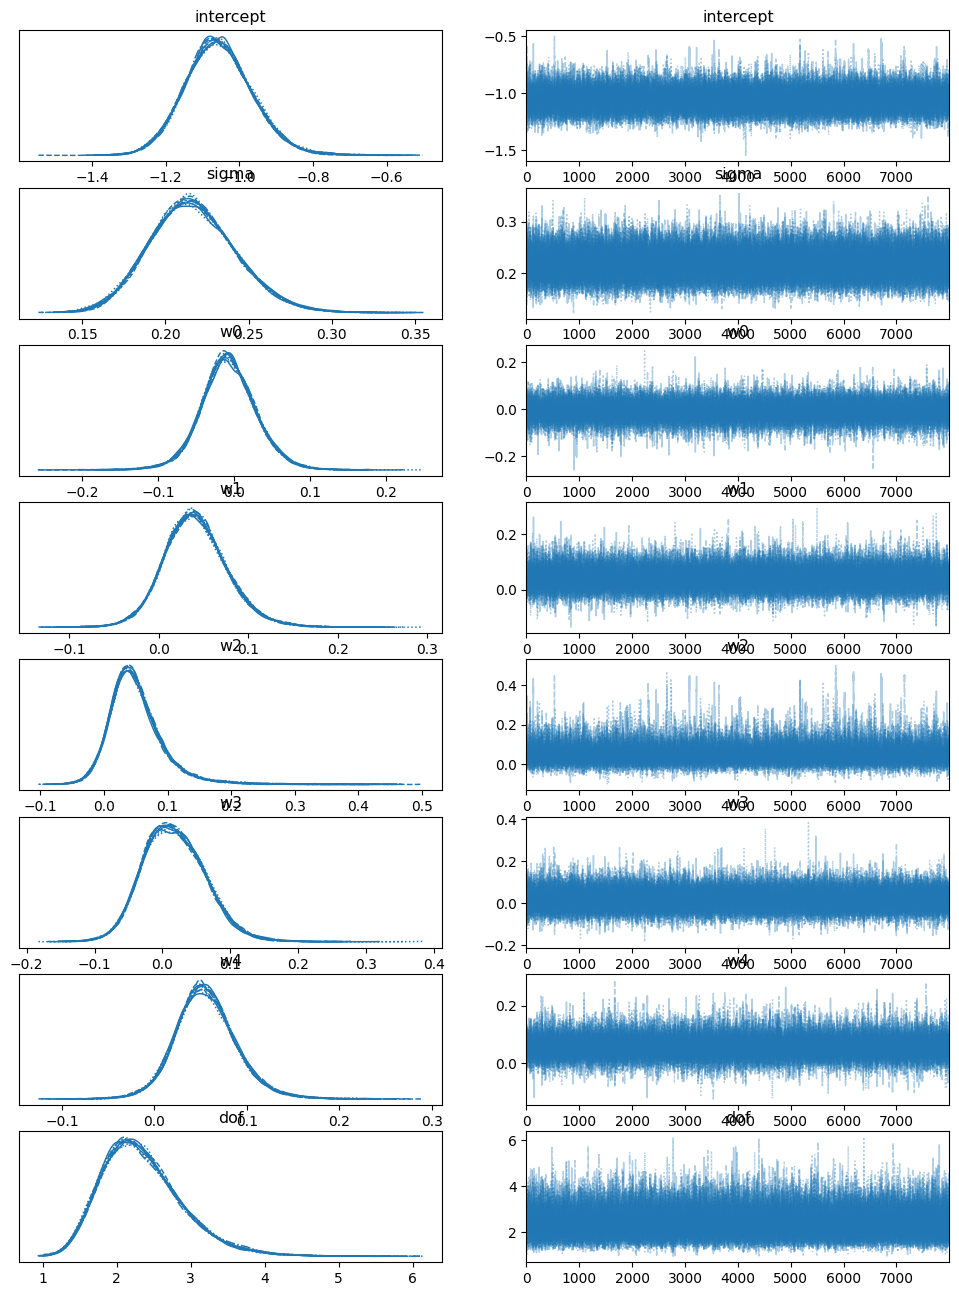

In [17]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'w0'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'w2'}>, <Axes: title={'center': 'w3'}>,
        <Axes: title={'center': 'w4'}>, <Axes: title={'center': 'dof'}>]],
      dtype=object)

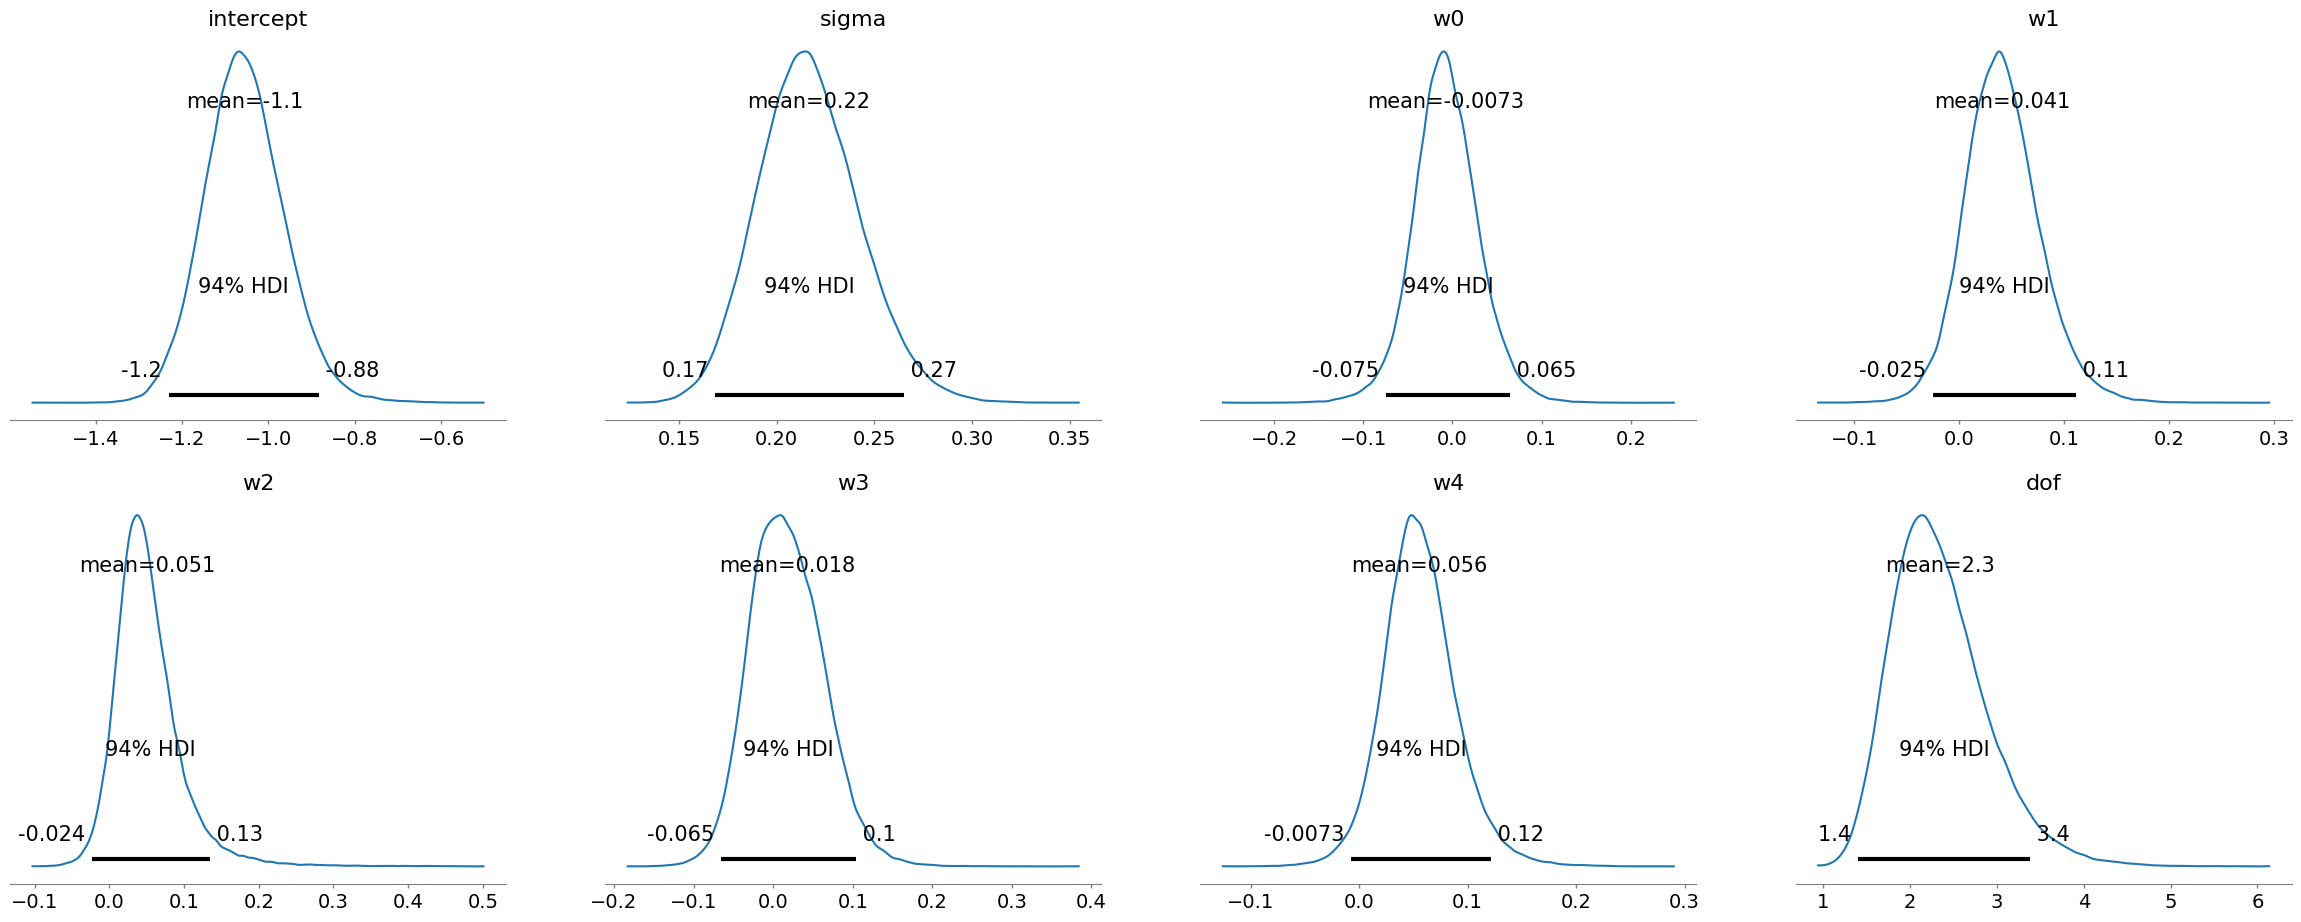

In [18]:
az.plot_posterior(idata)

In [19]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.056,0.093,-1.231,-0.884,0.000,0.000,46317.0,31554.0,1.0
sigma,0.217,0.026,0.168,0.265,0.000,0.000,63023.0,43698.0,1.0
w0,-0.007,0.037,-0.075,0.065,0.000,0.000,86518.0,47010.0,1.0
w1,0.041,0.036,-0.025,0.111,0.000,0.000,81841.0,46119.0,1.0
w2,0.051,0.046,-0.024,0.134,0.000,0.000,48801.0,23039.0,1.0
w3,0.018,0.046,-0.065,0.104,0.000,0.000,73885.0,48346.0,1.0
w4,0.056,0.034,-0.007,0.121,0.000,0.000,79616.0,41244.0,1.0
dof,2.346,0.553,1.396,3.381,0.002,0.002,69431.0,58106.0,1.0


In [20]:
with bayesmodel:
    post = idata.posterior
    pres = post['intercept'] + sum([post[wsnames[i]] *
    # XXX: In sample and out of sample too!
    xr.DataArray(test_samples[coefnames[i]]) for i in ARS])
    post['pres'] = pres
    test_response['pres'] = post['pres'].mean(dim=['chain', 'draw'])
    print('Out-sample r2: ', r2_score(test_response[v], test_response['pres'])*100)
    print('RMSE Out-sample: ', root_mean_squared_error(test_response[v], test_response['pres']))
    print('MAPE Out-sample: ', np.sum((test_response[v] - test_response['pres'])/test_response[v])/(test_response.shape[0])*100)

Out-sample r2:  13.778012986553934
RMSE Out-sample:  1.2868262533520076
MAPE Out-sample:  37.42061766041763


<Axes: ylabel='Frequency'>

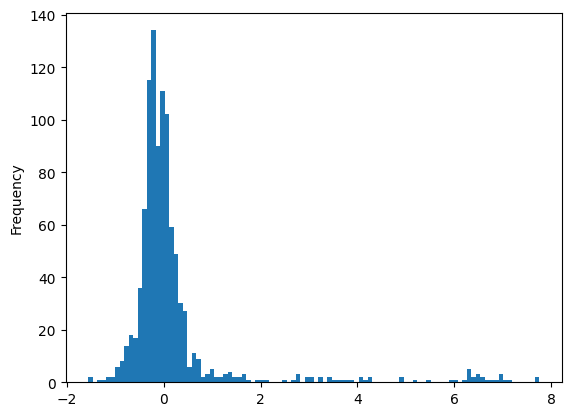

In [21]:
resids = (test_response[v] - test_response['pres'])
resids.plot.hist(bins=100)

In [22]:
with bayesmodel:
    pm.set_data({"tsamples": test_samples,
                 "tresponse": np.zeros(test_response.shape[0])})
    idata.extend(pm.sample_posterior_predictive(idata, predictions=False))

Sampling: [response]


Output()

In [23]:
bpred = idata.posterior_predictive['response'].median(['chain', 'draw'])
test_response['bpres'] = bpred
print(f'R2 predictive posterior: ', r2_score(test_response[v], test_response['bpres'])*100)
print('RMSE predictive posterior: ', root_mean_squared_error(test_response[v], test_response['bpres']))
print('MAPE predictive posterior: ', np.sum((test_response[v] - test_response['bpres'])/test_response[v])/(test_response.shape[0])*100)

R2 predictive posterior:  13.541166731039912
RMSE predictive posterior:  1.2885924557696191
MAPE predictive posterior:  37.435535975616865


<Axes: xlabel='date'>

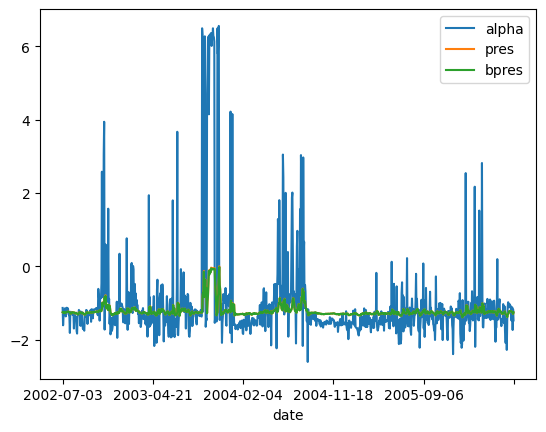

In [24]:
test_response.plot()

<Axes: ylabel='Frequency'>

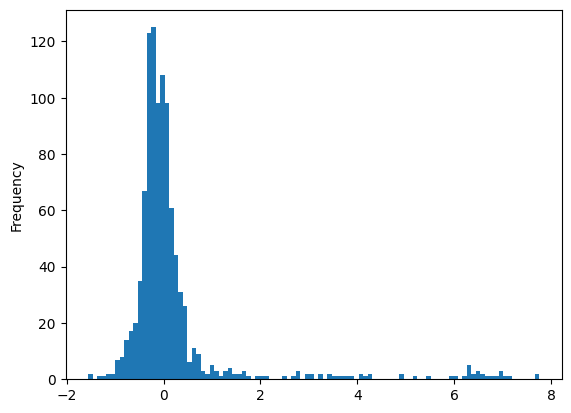

In [25]:
resids = (test_response[v] - test_response['bpres'])
resids.plot.hist(bins=100)

Real R2 predictive posterior:  -2.4533490856956552
Real RMSE predictive posterior:  82.65993628220802
MAPE predictive posterior:  -9.656198873154631


<Axes: title={'center': 'Final result for alpha'}, xlabel='date'>

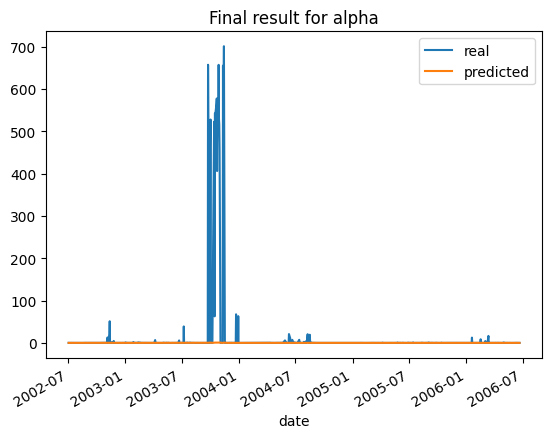

In [26]:
start = test_response[v].index[0]
end = test_response[v].index[-1]
real = dfo[v].loc[start:end]
preal = np.exp(test_response['bpres']) if v == 'alpha' else test_response['bpres']
resids = pd.DataFrame(real.values - preal.values, columns=['resids'])
print(f'Real R2 predictive posterior: ', r2_score(real, preal)*100)
print(f'Real RMSE predictive posterior: ', root_mean_squared_error(real, preal))
print('MAPE predictive posterior: ', np.sum((real.values - preal.values)/real)/(real.shape[0])*100)
final = pd.DataFrame({'real': real.values, 'predicted': preal.values})
final.index = real.index
final.head()
final.plot(title='Final result for %s' % v)

<Axes: ylabel='Frequency'>

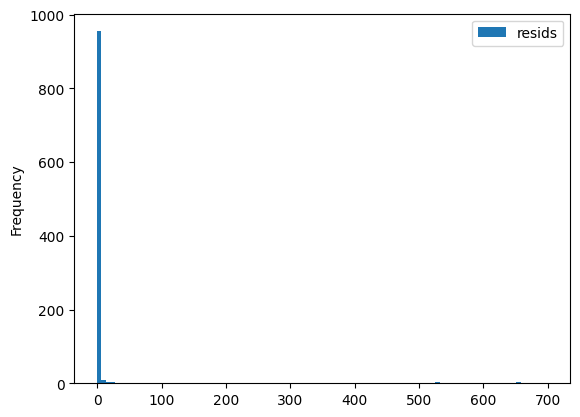

In [27]:
resids.index = real.index
resids.plot.hist(bins=100)